In [1]:
#some of the codes is re-use from pyimagesearch, thanks to Adrian Rosebrock
#https://www.pyimagesearch.com/
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
import time

def boundingBoxUsingOpenCV(image,cannyrangefrom,cannyrangeto, gaussianblur=5):
    # load the image, convert it to grayscale, and blur it slightly
    image = cv2.imread(image)
    (height,width,depth) = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (gaussianblur, gaussianblur), 0)

    edged = cv2.Canny(gray, 30, 120)
    plt.imshow(edged)
    # find contours in the edge map
    cnts= cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    (cnts, _) = contours.sort_contours(cnts)
    pixelsPerMetric = None

    temp_x_lower=int(width/2)
    temp_y_lower=int(height/2)
    temp_x_higher=int(width/2)
    temp_y_higher=int(height/2)
    for cnt in cnts:
        x,y,w,h = cv2.boundingRect(cnt)
        #print(x,y,x+w,y+h)
        if cv2.contourArea(cnt) > 100:
            if temp_x_higher+w  < (x+w):
                temp_x_higher =int(x+w)
            if temp_y_higher+h  < (y+h):
                temp_y_higher= int(y+h)
        
            if temp_x_lower > x:
                temp_x_lower=x
            if temp_y_lower > y: 
                temp_y_lower=y
        #print(temp_x_lower,temp_y_lower,temp_x_higher,temp_y_higher)
    bb_img = cv2.rectangle(image,(temp_x_lower,temp_y_lower),(int(temp_x_higher),int(temp_y_higher)),(0,255,0),10)
    print("Height:",temp_y_higher-temp_y_lower)
    print("Width:",temp_x_higher-temp_x_lower)
    plt.figure(figsize=(12,12))
    plt.imshow(bb_img)
    plt.show() 
    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable


Height: 1130
Width: 2767


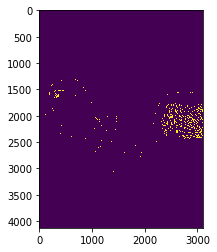

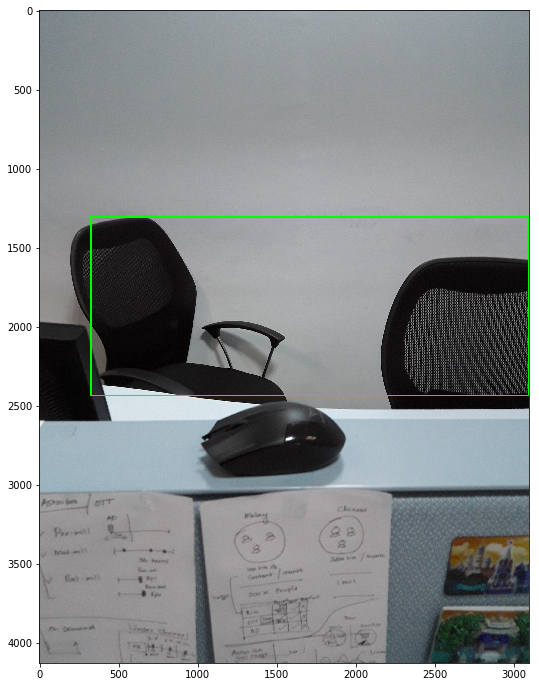

In [2]:
boundingBoxUsingOpenCV("office.jpg",30,120)

Height: 2750
Width: 2724


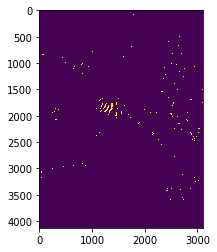

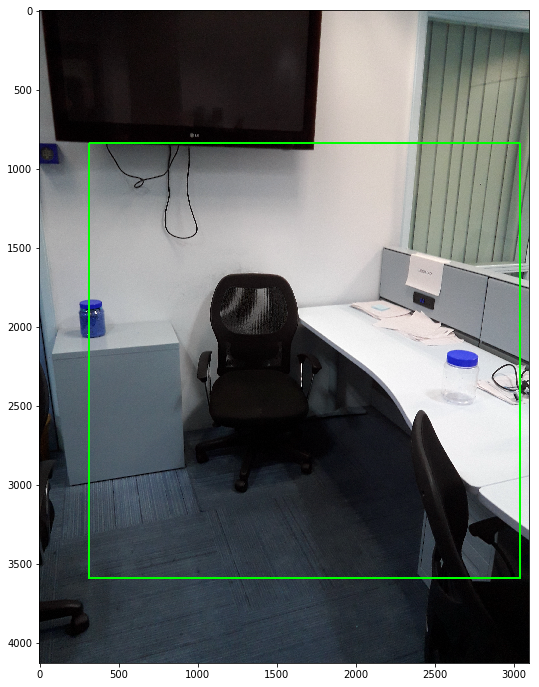

In [3]:
boundingBoxUsingOpenCV("office2.jpg",10,255,7)

In [4]:
#the above se used earlier to detect dog faces in tutorial fails. To rescue comes Deep Learning based Computer Vision
#YOLO, you looks only once is kind of single shot detector, which finds the appropriate bounding box

In [5]:
# derive the paths to the YOLO weights and model configuration
weightsPath = "C:\\Users\\User\\OpenCV tutorial\\yolo-coco\\yolov3.weights"
configPath = "C:\\Users\\User\\OpenCV tutorial\\yolo-coco\\yolov3.cfg"
labelsPath = "C:\\Users\\User\\OpenCV tutorial\\yolo-coco\\coco.names"
    


In [6]:
#some of the codes  below is reuse from pyimagesearch, thanks to Adrian Rosebrock
#https://www.pyimagesearch.com/
def BoundingBoxfromYolo(imageName,conf,thres,weightsPath,configPath,labelsPath):

    # load our YOLO object detector trained on COCO dataset (80 classes)
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
    np.random.seed(42)
    # initialize a list of colors to represent each possible class label
    LABELS = open(labelsPath).read().strip().split("\n")
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")
    image = cv2.imread(imageName)
    (H, W) = image.shape[:2]
    print(H,W)
    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    #print(ln)
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    print("output layer:",ln)

    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    print("Total time take to generate:", time.time()-start)

    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            scores = detection[5:]
            #print(scores)
            classID = np.argmax(scores)
            #print("the class with maximum score:",classID)
            confidence = scores[classID]
        
            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > conf:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences,conf,thres)
    objectDimensions={}
    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 10)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,confidence, color, 2)
            print("width:{}, height:{},class:{}".format(w,h,LABELS[classIDs[i]]))
            objectDimensions[LABELS[classIDs[i]]]=(w,h,confidences[i])
    
    # show the output image
    plt.figure(figsize=(12,12))
    plt.imshow(image)
    plt.show() 
    return objectDimensions

4128 3096
output layer: ['yolo_82', 'yolo_94', 'yolo_106']
Total time take to generate: 0.9859461784362793
width:1397, height:1042,class:chair


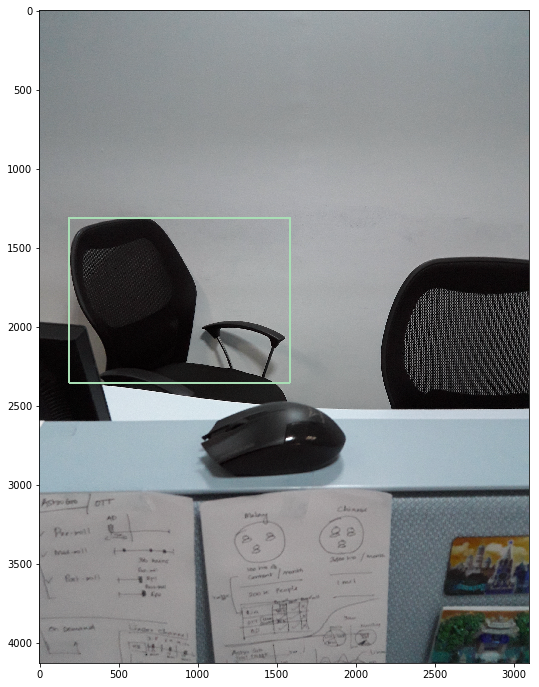

In [7]:
objectDimensions=BoundingBoxfromYolo("office.jpg",0.5,0.2,weightsPath,configPath,labelsPath)

4128 3096
output layer: ['yolo_82', 'yolo_94', 'yolo_106']
Total time take to generate: 0.8373105525970459
width:788, height:1407,class:chair
width:1891, height:888,class:tvmonitor
width:631, height:1633,class:chair


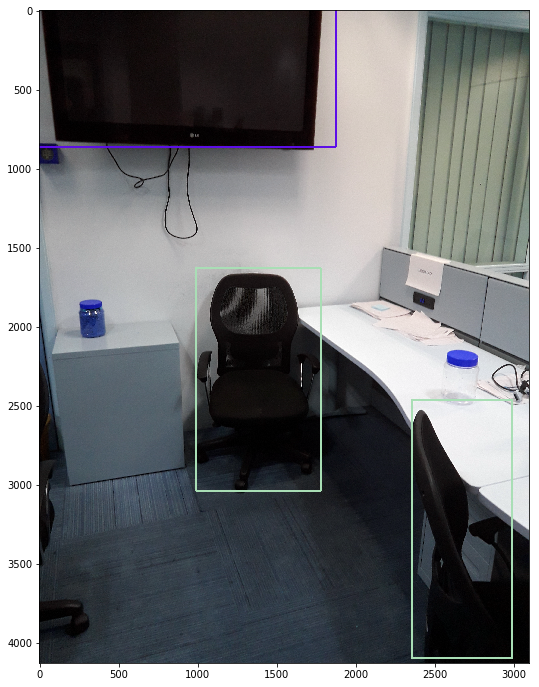

In [8]:
objectDimensions2=BoundingBoxfromYolo("office2.jpg",0.5,0.2,weightsPath,configPath,labelsPath)

In [9]:

!pip install ExifRead

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [10]:
import exifread
# Open image file for reading (binary mode)
def getFocalLength(pathname):
    f = open(pathname, 'rb')

    # Return Exif tags
    tags = exifread.process_file(f)
    return tags['EXIF FocalLength']

In [11]:
#checking the focal length for first image
getFocalLength('office.jpg')

(0x920A) Ratio=18/5 @ 688

In [12]:
#checking the focal length for second image
getFocalLength('office2.jpg')

(0x920A) Ratio=18/5 @ 688

In [13]:
#let's say we know that above chair was taken from distance of two meters and we saw focal length remained constant, now 
#distance of the object can be calculated  using the following formula: 
#hi/ho = - di/do
# where hi=image height of object detected
# ho = real height of object detected
# do= real distance between object and camera
#di= image distance between object and camera

#height and distance from first image is treated as real.

In [14]:
hi=objectDimensions2['chair'][1]

In [15]:
h0=objectDimensions['chair'][1]

In [16]:
d0=2

In [17]:
di=-(d0*hi/h0)

In [18]:
print("The distance of chair below the image is:",di)

The distance of chair below the image is: -3.1343570057581576


In [19]:
#caveat: 
#1.the orientation of chair is not considered
#2. in the first image, the height of chair is not full.

#find the way to overcome about two problems by finding the aspect ration of the given object
#integrate with YOLO9000 and see if it works
#making a distance  and relative spped calculation project for livestreaming video

